[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 13
[LightGBM] [Info] Start training from score 17.744906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23264\327847484.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method='bfill', inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23264\327847484.py:155: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method='ffill', inplace=True)


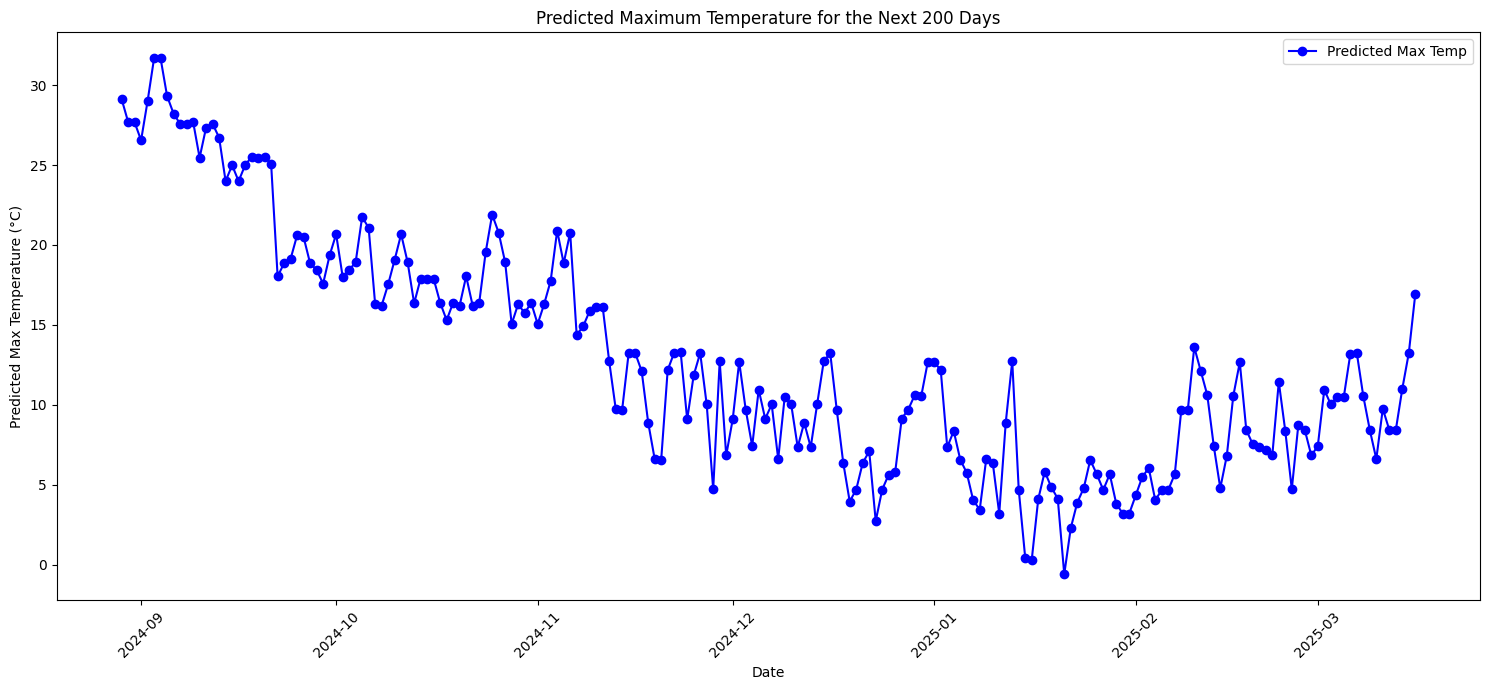

Stacked model processing complete.


In [1]:
# Filename: C:/Users/ADMIN/AI_asm2/models/StackModels/scripts/testStackModels.ipynb

# In[0]: IMPORT AND SETUP
#region 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import catboost as cb
import os
import pickle
#endregion

# Ensure the necessary directories exist
base_dir = "C:/Users/ADMIN/AI_asm2/models/StackModels"
os.makedirs(f"{base_dir}/preprocessing", exist_ok=True)
os.makedirs(f"{base_dir}/results", exist_ok=True)
os.makedirs(f"{base_dir}/figures", exist_ok=True)
os.makedirs(f"{base_dir}/models", exist_ok=True)

# In[1]: LOAD AND PREPARE DATA
file_path = "../../../data/NewYork.csv"  # Adjust this if the data path is different
data = pd.read_csv(file_path)

# Handle datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].dt.dayofyear

# Drop unnecessary columns
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset', 'preciptype', 'snow', 'conditions']
data = data.drop(columns=columns_to_drop)

# Handle missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Feature Engineering: Lag and rolling features
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)
data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['temp_precip_interaction'] = data['temp'] * data['precip']

# Drop rows with NaNs generated by lag features
data = data.dropna()

# Prepare features and target
features = ['tempmin', 'temp', 'humidity', 'windspeed', 'day_of_year_cos', 'day_of_year_sin', 
            'tempmax_lag1', 'tempmax_lag3', 'humidity_lag1', 'tempmax_rolling_mean_3', 
            'tempmax_rolling_std_3', 'precip_rolling_sum_7', 'temp_precip_interaction']
X = data[features]
y = data['tempmax']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
scaler_path = f"{base_dir}/preprocessing/scaler.pkl"
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# In[2]: DEFINE BASE MODELS
gb_model = GradientBoostingRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
cb_model = cb.CatBoostRegressor(verbose=0, random_state=42)

# In[3]: STACKING REGRESSOR
# Define the stacked model with Gradient Boosting as the meta-model
stacked_model = StackingRegressor(
    estimators=[
        ('gb', gb_model),
        ('lgb', lgb_model),
        ('cb', cb_model)
    ],
    final_estimator=GradientBoostingRegressor(random_state=42),
    cv=5
)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
y_pred = stacked_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Save evaluation metrics
with open(f"{base_dir}/results/model_evaluation.txt", "w") as file:
    file.write(f"R2 Score: {r2}\n")
    file.write(f"RMSE: {rmse}\n")
    file.write(f"MAE: {mae}\n")

print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Save the stacked model
model_path = f"{base_dir}/models/stacked_model.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(stacked_model, file)

print(f"Stacked model saved to {model_path}")

# In[4]: FUTURE PREDICTIONS
# Generate future dates
future_days = 200
start_date = pd.to_datetime('today').normalize()
future_dates = pd.date_range(start=start_date, periods=future_days, freq='D')

# Create a DataFrame for future predictions
future_data = pd.DataFrame({'datetime': future_dates})

# Prepare historical averages
feature_columns = ['tempmin', 'temp', 'humidity', 'windspeed', 'precip']
historical_averages = data.groupby('day_of_year')[feature_columns].mean().reset_index()

# Add 'day_of_year' to future_data
future_data['day_of_year'] = future_data['datetime'].dt.dayofyear

# Merge to get average feature values for future dates
future_data = future_data.merge(historical_averages, on='day_of_year', how='left')

# Engineer additional features similar to training data
future_data['tempmax_lag1'] = future_data['temp'].shift(1).fillna(future_data['temp'].mean())
future_data['tempmax_lag3'] = future_data['temp'].shift(3).fillna(future_data['temp'].mean())
future_data['humidity_lag1'] = future_data['humidity'].shift(1).fillna(future_data['humidity'].mean())
future_data['tempmax_rolling_mean_3'] = future_data['temp'].rolling(window=3).mean().fillna(future_data['temp'].mean())
future_data['tempmax_rolling_std_3'] = future_data['temp'].rolling(window=3).std().fillna(future_data['temp'].std())
future_data['precip_rolling_sum_7'] = future_data['precip'].rolling(window=7).sum().fillna(future_data['precip'].mean())
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / 365)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / 365)
future_data['temp_precip_interaction'] = future_data['temp'] * future_data['precip']

# Ensure all required columns are present (add missing columns with zeros)
required_columns = features
for col in required_columns:
    if col not in future_data.columns:
        future_data[col] = 0

# Fill missing values in future_data
future_data.fillna(method='bfill', inplace=True)
future_data.fillna(method='ffill', inplace=True)

# Scale the future data using the same scaler used for training data
future_data_scaled = scaler.transform(future_data[required_columns])

# Make predictions
future_tempmax_predictions = stacked_model.predict(future_data_scaled)

# Compile predictions
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Max_Temp': future_tempmax_predictions
})

# Save predictions
predictions_df.to_csv(f"{base_dir}/results/future_tempmax_predictions_200_days.csv", index=False)
print(f"Future predictions saved to {base_dir}/results/future_tempmax_predictions_200_days.csv")

# Visualization: Plot future predictions
plt.figure(figsize=(15, 7))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Max_Temp'], label='Predicted Max Temp', color='blue', marker='o')
plt.title('Predicted Maximum Temperature for the Next 200 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Max Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/future_tempmax_predictions.png")
plt.show()

print("Stacked model processing complete.")
